In [1]:
# Parallel Feature Extraction & Caching (depth-1 Stockfish)


# 1. Install & imports
!apt-get -qq install -y stockfish
!pip install -q python-chess stockfish pandas numpy joblib tqdm

import glob, os, pandas as pd, numpy as np, chess, joblib
from stockfish import Stockfish
from tqdm.notebook import tqdm
from multiprocessing import Pool, cpu_count

# 2. Paths & working dir
WORKDIR = '/kaggle/working/chess_cache'
os.makedirs(WORKDIR, exist_ok=True)
all_csv = glob.glob('/kaggle/input/**/*.csv', recursive=True)
TRAIN_CSV = [p for p in all_csv if 'chessData'    in p][0]
TEST_CSV  = [p for p in all_csv if 'random_evals' in p][0]

# 3. PST arrays & piece values
PST_PAWN = [  0,  5,  5, -5, -5,  5,  5,  0,   5, 10, 10,  0,  0, 10, 10,  5,
              5, -5,-10,  0,  0,-10, -5,  5,   0,  0,  0, 20, 20,  0,  0,  0,
              5,  5, 10, 25, 25, 10,  5,  5,  10, 10, 20, 30, 30, 20, 10, 10,
             50, 50, 50, 50, 50, 50, 50, 50,   0,  0,  0,  0,  0,  0,  0,  0 ]
PST_KN   = [-50,-40,-30,-30,-30,-30,-40,-50,  -40,-20,  0,  0,  0,  0,-20,-40,
            -30,  0, 10, 15, 15, 10,  0,-30,  -30,  5, 15, 20, 20, 15,  5,-30,
            -30,  0, 15, 20, 20, 15,  0,-30,  -30,  5, 10, 15, 15, 10,  5,-30,
            -40,-20,  0,  5,  5,  0,-20,-40,  -50,-40,-30,-30,-30,-30,-40,-50 ]
PST_BI   = [-20,-10,-10,-10,-10,-10,-10,-20,  -10,  0,  0,  0,  0,  0,  0,-10,
            -10,  0,  5, 10, 10,  5,  0,-10,  -10,  5,  5, 10, 10,  5,  5,-10,
            -10,  0, 10, 10, 10, 10,  0,-10,  -10, 10, 10, 10, 10, 10, 10,-10,
            -10,  5,  0,  0,  0,  0,  5,-10,  -20,-10,-10,-10,-10,-10,-10,-20 ]
PST_RO   = [0,0,5,10,10,5,0,0]*6 + [25]*8 + [0,0,5,10,10,5,0,0]
PST_QU   = [-10, -8, -6, -4, -4, -6, -8,-10,  -8, -6, -4, -2, -2, -4, -6, -8,
            -6, -4, -2,  0,  0, -2, -4, -6,  -4, -2,  0,  2,  2,  0, -2, -4,
            -4, -2,  0,  2,  2,  0, -2, -4,  -6, -4, -2,  0,  0, -2, -4, -6,
            -8, -6, -4, -2, -2, -4, -6, -8, -10, -8, -6, -4, -4, -6, -8,-10 ]
PSTS = {1:PST_PAWN, 2:PST_KN, 3:PST_BI, 4:PST_RO, 5:PST_QU}
VALS = {1:1, 2:3, 3:3, 4:5, 5:9}
MATE_CP, CLIP = 10000, 1000

# 4. Pool initializer: each worker gets its own Stockfish instance
def init_worker():
    global sf
    sf = Stockfish(path='/usr/games/stockfish',
                   parameters={"Threads":1, "Hash":8},
                   depth=1)

# 5. Label parser
def parse_eval(v):
    s = str(v).strip()
    if s.startswith('#'):
        return MATE_CP if '+' in s else -MATE_CP
    try: return float(s)
    except: return np.nan

# 6. Feature extraction using global sf
def fen2feat(fen):
    b = chess.Board(fen)
    f = {}
    # counts + PST
    for p in chess.PIECE_TYPES:
        w,bl = len(b.pieces(p,True)), len(b.pieces(p,False))
        f[f'w_cnt_{p}'], f[f'b_cnt_{p}'] = w, bl
        if p in PSTS:
            f[f'pst_w_{p}'] = sum(PSTS[p][sq] for sq in b.pieces(p,True))
            f[f'pst_b_{p}'] = sum(PSTS[p][chess.square_mirror(sq)]
                                 for sq in b.pieces(p,False))
    # material
    f['material'] = sum((f[f'w_cnt_{p}']-f[f'b_cnt_{p}'])*VALS[p] for p in VALS)
    # side & castling
    f['active_w'] = int(b.turn)
    f['castle_wk'],f['castle_wq'] = map(int,(
        b.has_kingside_castling_rights(True),
        b.has_queenside_castling_rights(True)))
    f['castle_bk'],f['castle_bq'] = map(int,(
        b.has_kingside_castling_rights(False),
        b.has_queenside_castling_rights(False)))
    # mobility
    f['mob_w'] = b.legal_moves.count()
    b.turn = not b.turn
    f['mob_b'] = b.legal_moves.count()
    # Stockfish d=1 eval
    sf.set_fen_position(fen)
    ev = sf.get_evaluation()
    if ev['type']=='cp':
        f['sf_cp'], f['sf_mate'] = ev['value'], 0
    else:
        f['sf_cp'], f['sf_mate'] = np.sign(ev['value'])*MATE_CP, 1
    return f

# 7. Worker function
def process_row(args):
    fen, eval_str = args
    feats = fen2feat(fen)
    if feats is None: return None
    feats['label'] = parse_eval(eval_str)
    return feats

# 8. Parallel extraction
def extract_parallel(csv_path, prefix, N=None, workers=None):
    df = pd.read_csv(csv_path, usecols=['FEN','Evaluation'])
    if N: df = df.sample(N, random_state=42)
    rows = list(df.itertuples(index=False, name=None))
    w = workers or max(cpu_count()-1,1)
    with Pool(w, initializer=init_worker) as pool:
        results = list(tqdm(pool.imap(process_row, rows), total=len(rows)))
    feats = pd.DataFrame([r for r in results if r])
    y     = feats.pop('label').clip(-CLIP, CLIP)
    feats.to_parquet(f'{WORKDIR}/{prefix}X.parquet')
    y.to_pickle(  f'{WORKDIR}/{prefix}y.pkl')
    print(f"{prefix} → {feats.shape}")

# 9. Run extraction on Kaggle GPU runtime (2 vCPUs)
extract_parallel(TRAIN_CSV, 'train_', N=5_000_000, workers=2)
extract_parallel(TEST_CSV,  'test_',  N=500_000,   workers=2)
print("Extraction complete ✅")


Selecting previously unselected package stockfish.
(Reading database ... 128691 files and directories currently installed.)
Preparing to unpack .../stockfish_14.1-1_amd64.deb ...
Unpacking stockfish (14.1-1) ...
Setting up stockfish (14.1-1) ...
Processing triggers for man-db (2.10.2-1) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 79.4 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done


  0%|          | 0/5000000 [00:00<?, ?it/s]

train_ → (5000000, 32)


  0%|          | 0/500000 [00:00<?, ?it/s]

test_ → (500000, 32)
Extraction complete ✅


In [2]:
# Scale, Optuna‐tune & GPU‐train XGBoost on 5 M train / 500 k test

# 1. Install dependencies
!pip install -q pandas numpy scikit-learn xgboost joblib optuna

# 2. Imports
import pandas as pd
import joblib
import xgboost as xgb
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

# 3. Load cached features
WORKDIR = '/kaggle/working/chess_cache'
X_tr = pd.read_parquet(f'{WORKDIR}/train_X.parquet')
y_tr = pd.read_pickle (f'{WORKDIR}/train_y.pkl')
X_te = pd.read_parquet(f'{WORKDIR}/test_X.parquet')
y_te = pd.read_pickle (f'{WORKDIR}/test_y.pkl')

# 4. Scale features
scaler  = StandardScaler().fit(X_tr)
X_tr_s  = scaler.transform(X_tr)
X_te_s  = scaler.transform(X_te)
joblib.dump(scaler, f'{WORKDIR}/scaler_5M.joblib')

# 5. Quick Optuna tuning on a 1 M‐row slice 
SLICE = 1_000_000
Xt, yt = shuffle(X_tr_s, y_tr, random_state=42)[:SLICE]
d_tune = xgb.DMatrix(Xt, label=yt)

def objective(trial):
    params = {
        'eta':              trial.suggest_float('eta', 0.02, 0.10, log=True),
        'max_depth':        trial.suggest_int('max_depth', 6, 12),
        'subsample':        trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda':           trial.suggest_float('lambda', 1e-3, 10, log=True),
        'objective':        'reg:squarederror',
        'tree_method':      'gpu_hist',
        'eval_metric':      'rmse'
    }
    bst = xgb.train(
        params,
        d_tune,
        num_boost_round=800,
        evals=[(d_tune, 'val')],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    return bst.best_score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=12, timeout=900)
best_params = study.best_params
print("Best slice RMSE:", study.best_value)
print("Best params:", best_params)

# 6. Final training on full 5 M / 500 k 
dtrain = xgb.DMatrix(X_tr_s, label=y_tr)
dtest  = xgb.DMatrix(X_te_s, label=y_te)

bst = xgb.train(
    best_params,
    dtrain,
    num_boost_round=1200,
    evals=[(dtest, 'test')],
    early_stopping_rounds=100,
    verbose_eval=100
)

# 7. Evaluate & save
preds = bst.predict(dtest)
rmse  = mean_squared_error(y_te, preds) ** 0.5
r2    = r2_score(y_te, preds)
print(f"★ FINAL RMSE {rmse:.1f} cp | R² {r2:.3f}")

joblib.dump(
    {'scaler': scaler, 'model': bst, 'clip': (-1000, 1000)},
    f'{WORKDIR}/quickEval_sf1_xgb_gpu_5M.joblib'
)
print("Model saved → quickEval_sf1_xgb_gpu_5M.joblib")


[I 2025-05-04 18:38:47,100] A new study created in memory with name: no-name-8ec3616e-8acd-47ec-8c55-ea1472dbbff0
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [18:38:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-05-04 18:39:28,185] Trial 0 finished with value: 157.41406309775113 and parameters: {'eta': 0.07490178528234599, 'max_depth': 9, 'subsample': 0.8133796339228863, 'colsample_bytree': 0.8931762835935674, 'lambda': 0.03192124479249113}. Best is trial 0 with value: 157.41406309775113.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [18:39:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g

Best slice RMSE: 145.82224833733346
Best params: {'eta': 0.03473735509521597, 'max_depth': 12, 'subsample': 0.6628658540647194, 'colsample_bytree': 0.8046443515581669, 'lambda': 0.004595816185871391}
[0]	test-rmse:594.35624
[100]	test-rmse:257.36096
[200]	test-rmse:252.61069
[276]	test-rmse:253.66551
★ FINAL RMSE 253.7 cp | R² 0.827
Model saved → quickEval_sf1_xgb_gpu_5M.joblib


Full‐range benchmark (±1000 cp):
  Full → RMSE: 294.2 cp, MAE: 203.1 cp, R²: 0.802

Mid‐game benchmark (|eval|<500 cp):
  Mid → RMSE: 126.0 cp, MAE: 88.9 cp, R²: 0.672


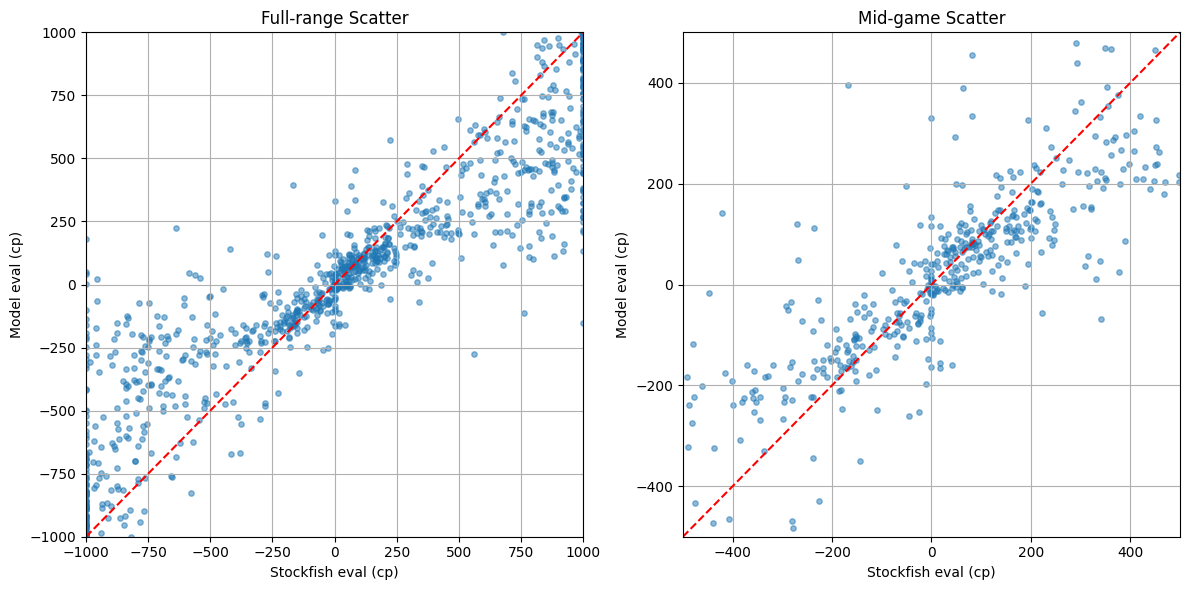

In [7]:
# Extended Benchmark with Full‐Range & Mid‐Game Metrics

# 1. Install & imports
!pip install -q python-chess stockfish pandas numpy matplotlib joblib xgboost
import pandas as pd
import numpy as np
import chess
import joblib
import xgboost as xgb
from stockfish import Stockfish
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 2. Load model + scaler + clip
WORKDIR    = '/kaggle/working/chess_cache'
artifact   = joblib.load(f'{WORKDIR}/quickEval_sf1_xgb_gpu_5M.joblib')
scaler     = artifact['scaler']
bst        = artifact['model']      # xgboost.core.Booster
clip_min, clip_max = artifact['clip']

# 3. Prepare Stockfish engines
sf_d1  = Stockfish(path='/usr/games/stockfish', parameters={"Threads":2,"Hash":16}, depth=1)
sf_d12 = Stockfish(path='/usr/games/stockfish', parameters={"Threads":2,"Hash":16}, depth=12)

# 4. Feature‐extraction 

def fen2feat(fen: str) -> pd.DataFrame:
    b = chess.Board(fen)
    f = {}
    for p in chess.PIECE_TYPES:
        w, bl = len(b.pieces(p, True)), len(b.pieces(p, False))
        f[f'w_cnt_{p}'], f[f'b_cnt_{p}'] = w, bl
        if p in PSTS:
            f[f'pst_w_{p}'] = sum(PSTS[p][sq] for sq in b.pieces(p, True))
            f[f'pst_b_{p}'] = sum(PSTS[p][chess.square_mirror(sq)] for sq in b.pieces(p, False))
    f['material'] = sum((f[f'w_cnt_{p}'] - f[f'b_cnt_{p}']) * VALS[p] for p in VALS)
    f['active_w'] = int(b.turn)
    f['castle_wk'], f['castle_wq'] = map(int, (
        b.has_kingside_castling_rights(True),
        b.has_queenside_castling_rights(True)))
    f['castle_bk'], f['castle_bq'] = map(int, (
        b.has_kingside_castling_rights(False),
        b.has_queenside_castling_rights(False)))
    f['mob_w'] = b.legal_moves.count()
    b.turn = not b.turn
    f['mob_b'] = b.legal_moves.count()
    # add depth-1 SF feature
    sf_d1.set_fen_position(fen)
    ev1 = sf_d1.get_evaluation()
    if ev1['type'] == 'cp':
        f['sf_cp'], f['sf_mate'] = ev1['value'], 0
    else:
        f['sf_cp'], f['sf_mate'] = np.sign(ev1['value']) * 10000, 1
    # ensure column order
    cols = list(scaler.feature_names_in_)
    return pd.DataFrame([[f[c] for c in cols]], columns=cols)

# 5. Load & sample test FENs

df = pd.read_csv(TEST_CSV, usecols=['FEN']).dropna().sample(1000, random_state=42)

engine_full, model_full = [], []
engine_mid,  model_mid  = [], []

for fen in df['FEN']:
    # engine ground-truth at depth 12
    sf_d12.set_fen_position(fen)
    ev12 = sf_d12.get_evaluation()
    cp12 = ev12['value'] if ev12['type']=='cp' else np.sign(ev12['value'])*10000
    cp_clip = np.clip(cp12, clip_min, clip_max)
    engine_full.append(cp_clip)
    # model prediction
    Xf = fen2feat(fen)
    pred = bst.predict(xgb.DMatrix(scaler.transform(Xf)))[0]
    mp = np.clip(pred, clip_min, clip_max)
    model_full.append(mp)
    # mid-game subset
    if abs(cp_clip) < 500:
        engine_mid.append(cp_clip)
        model_mid.append(mp)

engine_full = np.array(engine_full)
model_full  = np.array(model_full)
engine_mid  = np.array(engine_mid)
model_mid   = np.array(model_mid)

# 6. Compute & print metrics
def print_metrics(y_true, y_pred, label):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = mse**0.5
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{label} → RMSE: {rmse:.1f} cp, MAE: {mae:.1f} cp, R²: {r2:.3f}")

print("Full‐range benchmark (±1000 cp):")
print_metrics(engine_full, model_full, "  Full")

print("\nMid‐game benchmark (|eval|<500 cp):")
print_metrics(engine_mid, model_mid, "  Mid")

# 7. Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, y_t, y_p, title in zip(axes,
                               [engine_full, engine_mid],
                               [model_full, model_mid],
                               ['Full‐range', 'Mid‐game']):
    ax.scatter(y_t, y_p, alpha=0.5, s=15)
    lims = [clip_min, clip_max] if title=='Full‐range' else [-500, 500]
    ax.plot(lims, lims, 'r--')
    ax.set_title(f"{title} Scatter")
    ax.set_xlabel('Stockfish eval (cp)')
    ax.set_ylabel('Model eval (cp)')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.grid(True)

plt.tight_layout()
plt.show()
